In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pqcd
import h5py
import corner

from universality.gaussianprocess.utils import integrate_phi
from pqcd.utils import (
    to_GeV_per_cubic_femtometre, 
    to_nucleons_per_cubic_femtometre,
    nsat
    )

Load a single tabulated EOS

In [2]:
file_path = '../make-agnostic-processes/hadagn/bsk/gpr_gpr_hadronic-bsk.hdf5'

In [3]:
with h5py.File(file_path, 'r') as f:
    print(f['0'].keys())

<KeysViewHDF5 ['cov', 'mean']>


In [4]:
with h5py.File(file_path, 'r') as f:
    cov = np.array(f['0']['cov'])
    mean = np.array(f['0']['mean'])

In [5]:
log_pressure = np.array([entry[0] for entry in mean])
phi = np.array([entry[1] for entry in mean])

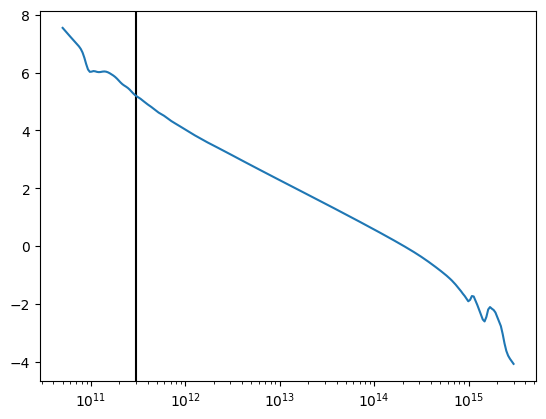

In [6]:
fig, ax = plt.subplots()
ax.set_xscale('log')

ax.plot(np.exp(log_pressure), phi)

# integrate_phi_reference_pressure
ax.axvline(3e11, c='k', zorder=0.5)

Is this the correct way to integrate?

In [7]:
eos, cols = integrate_phi(
    np.exp(log_pressure),
    phi,
    reference_pressurec2=3e11,
    sigma_logpressurec2=0,
    stitch_below_reference_pressure=True,
    include_baryon_density=True,
    include_cs2c2=True,
    include_baryon_chemical_potential=False,
    verbose=True
)

performing numeric integration for energy_density via trapazoidal approximation
performing numeric integration for baryon_density via trapazoidal approximation
computing cs2c2 via numeric differentiation


In [8]:
eos, cols

(array([[3.36295248e-07, 1.31539386e+01, 1.31539389e+01, 6.35677634e-08],
        [2.14431941e-06, 4.15964079e+01, 4.15964072e+01, 7.90900128e-08],
        [1.36728240e-05, 1.31539403e+02, 1.31539389e+02, 1.59474159e-07],
        ...,
        [2.74626556e+15, 3.98608023e+15, 2.27836117e+15, 9.79858908e-01],
        [2.87033041e+15, 4.11256625e+15, 2.32078011e+15, 9.81638192e-01],
        [3.00000000e+15, 4.24455192e+15, 2.36424677e+15, 9.82452028e-01]]),
 ['pressurec2', 'energy_densityc2', 'baryon_density', 'cs2c2'])

In [9]:
pressure_mean = to_GeV_per_cubic_femtometre(eos[:, cols.index('pressurec2')])
energy_density_mean = to_GeV_per_cubic_femtometre(eos[:, cols.index('energy_densityc2')])
number_density_mean = to_nucleons_per_cubic_femtometre(eos[:, cols.index('baryon_density')])

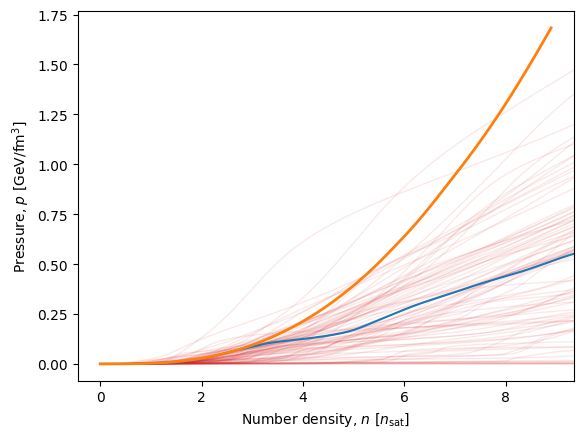

In [10]:
sets = [2, 0, 1]
N_samp = 10

good_EOSs = {s: [] for s in sets}

pqcd_region_dict = pqcd.get_pqcd_region()

fig, ax = plt.subplots()

ax.plot(number_density_mean/nsat, pressure_mean, c='C1', zorder=3, lw=2)

xlim = ax.get_xlim()
ylim = ax.get_ylim()

for s in sets:
    for variety in ['had', 'hyp', 'qrk']:
        for ni in range(N_samp):

            eos = pd.read_csv(f'../data/eos-draws-modified/{s:02}/{variety}agn/eos-draw-{ni:06}.csv')
            
            if pqcd.consistent_with_pqcd(eos, pqcd_region_dict):
                good_EOSs[s].append((variety, ni))
                ax.plot(
                    to_nucleons_per_cubic_femtometre(eos.baryon_density)/nsat,
                    to_GeV_per_cubic_femtometre(eos.pressurec2),
                    c='C0'
                )
            
            else:
                ax.plot(
                    to_nucleons_per_cubic_femtometre(eos.baryon_density)/nsat,
                    to_GeV_per_cubic_femtometre(eos.pressurec2),
                    c='C3',
                    alpha=0.1,
                    lw=1,
                    zorder=0.5
                )

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel(r'Number density, $n$ [$n_{\rm sat}$]')
_ = ax.set_ylabel(r'Pressure, $p$ [GeV/fm$^3$]')

We can check the integration by using one of the EOS draws

performing numeric integration for energy_density via trapazoidal approximation
performing numeric integration for baryon_density via trapazoidal approximation
computing cs2c2 via numeric differentiation
performing numeric integration for energy_density via trapazoidal approximation
performing numeric integration for baryon_density via trapazoidal approximation
computing cs2c2 via numeric differentiation
performing numeric integration for energy_density via trapazoidal approximation
performing numeric integration for baryon_density via trapazoidal approximation
computing cs2c2 via numeric differentiation
performing numeric integration for energy_density via trapazoidal approximation
performing numeric integration for baryon_density via trapazoidal approximation
computing cs2c2 via numeric differentiation
performing numeric integration for energy_density via trapazoidal approximation
performing numeric integration for baryon_density via trapazoidal approximation
computing cs2c2 via nume

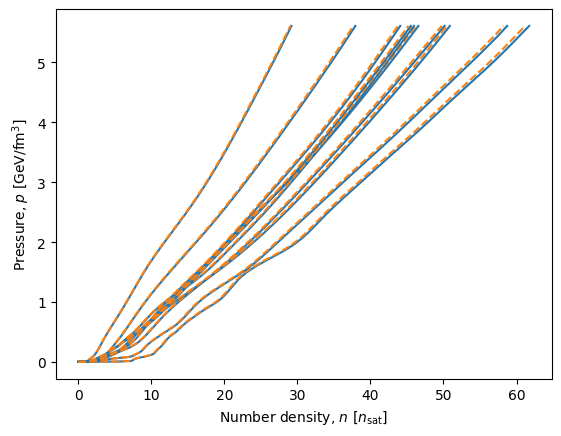

In [11]:
set = 6

repeats = 10
rng = np.random.default_rng()

fig, ax = plt.subplots()

for _ in range(repeats):

    i = rng.integers(0, 2, endpoint=True)
    variety = ['had', 'hyp', 'qrk'][i]

    n = rng.integers(0, 2000, endpoint=True)

    eos = pd.read_csv(f'../data/eos-draws-modified/{set:02}/{variety}agn/DRAWmod1000-{int(n/1000):06}/eos-draw-{n:06}.csv')
    gp = pd.read_csv(f'../data/eos-draws-modified/{set:02}/{variety}agn/DRAWmod1000-{int(n/1000):06}/draw-gpr_{variety}agn-{n:06}.csv', comment='#')

    eos_integrated, cols = integrate_phi(
        np.exp(gp['log(pressurec2)']).values,
        gp['phi'].values,
        reference_pressurec2=3e11,
        sigma_logpressurec2=0,
        stitch_below_reference_pressure=True,
        include_baryon_density=True,
        include_cs2c2=True,
        include_baryon_chemical_potential=False,
        verbose=True
    )

    ax.plot(
        to_nucleons_per_cubic_femtometre(eos.baryon_density)/nsat, 
        to_GeV_per_cubic_femtometre(eos.pressurec2), 
        c='C0', 
        )

    ax.plot(
        to_nucleons_per_cubic_femtometre(eos_integrated[:, cols.index('baryon_density')])/nsat, 
        to_GeV_per_cubic_femtometre(eos_integrated[:, cols.index('pressurec2')]), 
        c='C1', 
        ls='--',
        )

ax.set_xlabel(r'Number density, $n$ [$n_{\rm sat}$]')
_ = ax.set_ylabel(r'Pressure, $p$ [GeV/fm$^3$]')

Plot all tabulated EOSs

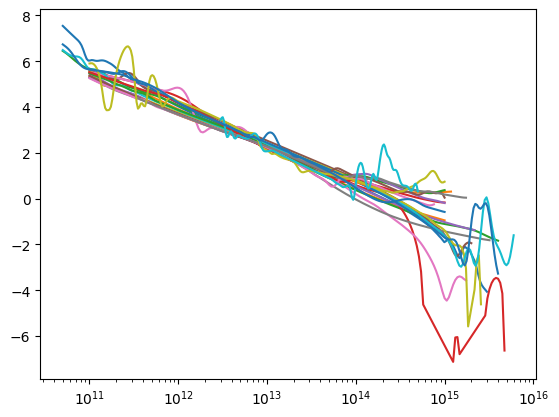

In [12]:
hdf5_paths = {
    'had': ['bsk', 'bsr', 'dd', 'eng', 'gm', 'kde', 'mpa', 'nl', 'r', 'sk', 'sly', 'tm'],
    'hyp': ['bsr', 'dd', 'gm', 'h', 'nl', 'tm'],
    'qrk': ['alf', 'ddq', 'hqc']
}

fig, ax = plt.subplots()
ax.set_xscale('log')

for variety in ['had', 'hyp', 'qrk']:

    for label in hdf5_paths[variety]:

        if variety == 'had':
            file_path = f'../make-agnostic-processes/{variety}agn/{label}/gpr_gpr_{variety}ronic-{label}.hdf5'
        elif variety == 'hyp':
            file_path = f'../make-agnostic-processes/{variety}agn/{label}/gpr_gpr_{variety}eronic-{label}.hdf5'
        elif variety == 'qrk':
            file_path = f'../make-agnostic-processes/{variety}agn/{label}/gpr_gpr_quark-{label}.hdf5'
        
        with h5py.File(file_path, 'r') as f:
            cov = np.array(f['0']['cov'])
            mean = np.array(f['0']['mean'])

        log_pressure = np.array([entry[0] for entry in mean])
        phi = np.array([entry[1] for entry in mean])

        ax.plot(np.exp(log_pressure), phi)

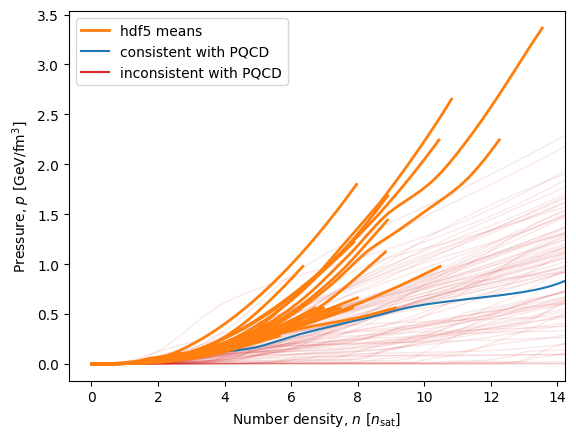

In [13]:
fig, ax = plt.subplots()

for variety in ['had', 'hyp', 'qrk']:
    for path in hdf5_paths[variety]:

        if variety == 'had':
            file_path = f'../make-agnostic-processes/{variety}agn/{path}/gpr_gpr_{variety}ronic-{path}.hdf5'
        elif variety == 'hyp':
            file_path = f'../make-agnostic-processes/{variety}agn/{path}/gpr_gpr_{variety}eronic-{path}.hdf5'
        elif variety == 'qrk':
            file_path = f'../make-agnostic-processes/{variety}agn/{path}/gpr_gpr_quark-{path}.hdf5'

        with h5py.File(file_path, 'r') as f:
            cov = np.array(f['0']['cov'])
            mean = np.array(f['0']['mean'])

        log_pressure = np.array([entry[0] for entry in mean])
        phi = np.array([entry[1] for entry in mean])

        eos, cols = integrate_phi(
            np.exp(log_pressure),
            phi,
            reference_pressurec2=3e11,
            sigma_logpressurec2=0,
            stitch_below_reference_pressure=True,
            include_baryon_density=True,
            include_cs2c2=True,
            include_baryon_chemical_potential=False,
            verbose=False
        )

        pressure_mean = to_GeV_per_cubic_femtometre(eos[:, cols.index('pressurec2')])
        energy_density_mean = to_GeV_per_cubic_femtometre(eos[:, cols.index('energy_densityc2')])
        number_density_mean = to_nucleons_per_cubic_femtometre(eos[:, cols.index('baryon_density')])

        ax.plot(number_density_mean/nsat, pressure_mean, c='C1', zorder=3, lw=2)

xlim = ax.get_xlim()
ylim = ax.get_ylim()

sets = [2, 0, 1]
N_samp = 10

good_EOSs = {s: [] for s in sets}

pqcd_region_dict = pqcd.get_pqcd_region()

for s in sets:
    for variety in ['had', 'hyp', 'qrk']:
        for ni in range(N_samp):

            eos = pd.read_csv(f'../data/eos-draws-modified/{s:02}/{variety}agn/eos-draw-{ni:06}.csv')
            
            if pqcd.consistent_with_pqcd(eos, pqcd_region_dict):
                good_EOSs[s].append((variety, ni))
                ax.plot(
                    to_nucleons_per_cubic_femtometre(eos.baryon_density)/nsat,
                    to_GeV_per_cubic_femtometre(eos.pressurec2),
                    c='C0'
                )
            
            else:
                ax.plot(
                    to_nucleons_per_cubic_femtometre(eos.baryon_density)/nsat,
                    to_GeV_per_cubic_femtometre(eos.pressurec2),
                    c='C3',
                    alpha=0.1,
                    lw=1,
                    zorder=0.5
                )

ax.set_xlim(xlim)
ax.set_ylim(ylim)

labels = ['hdf5 means', 'consistent with PQCD', 'inconsistent with PQCD']
handles = [
    plt.Line2D([0], [0], color='C1', lw=2), 
    plt.Line2D([0], [0], color='C0'), 
    plt.Line2D([0], [0], color='C3')
    ]

ax.legend(handles, labels)

ax.set_xlabel(r'Number density, $n$ [$n_{\rm sat}$]')
_ = ax.set_ylabel(r'Pressure, $p$ [GeV/fm$^3$]')

Plot EOSs in the pressure-phi space

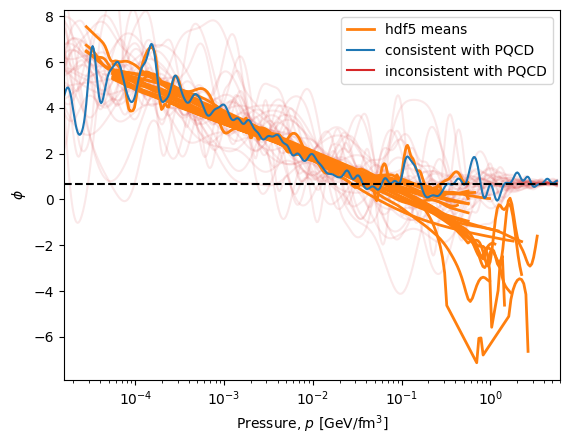

In [14]:
fig, ax = plt.subplots()
ax.set_xscale('log')

for variety in ['had', 'hyp', 'qrk']:
    for path in hdf5_paths[variety]:

        if variety == 'had':
            file_path = f'../make-agnostic-processes/{variety}agn/{path}/gpr_gpr_{variety}ronic-{path}.hdf5'
        elif variety == 'hyp':
            file_path = f'../make-agnostic-processes/{variety}agn/{path}/gpr_gpr_{variety}eronic-{path}.hdf5'
        elif variety == 'qrk':
            file_path = f'../make-agnostic-processes/{variety}agn/{path}/gpr_gpr_quark-{path}.hdf5'

        with h5py.File(file_path, 'r') as f:
            cov = np.array(f['0']['cov'])
            mean = np.array(f['0']['mean'])

        log_pressure = np.array([entry[0] for entry in mean])
        phi = np.array([entry[1] for entry in mean])

        ax.plot(to_GeV_per_cubic_femtometre(np.exp(log_pressure)), phi, c='C1', zorder=1, lw=2)

xlim = ax.get_xlim()
ylim = ax.get_ylim()

sets = [0]
N_samp = 10

pqcd_region_dict = pqcd.get_pqcd_region()

for s in sets:
    for variety in ['had', 'hyp', 'qrk']:
        for ni in range(N_samp):

            eos = pd.read_csv(f'../data/eos-draws-modified/{s:02}/{variety}agn/eos-draw-{ni:06}.csv')
            
            if pqcd.consistent_with_pqcd(eos, pqcd_region_dict):
                c='C0'
                alpha=1
                zorder=2
            
            else:
                c='C3'
                alpha=0.1
                zorder=0.5

            gp = pd.read_csv(f'../data/eos-draws-modified/{s:02}/{variety}agn/draw-gpr_{variety}agn-{ni:06}.csv')
            
            ax.plot(
                to_GeV_per_cubic_femtometre(np.exp(gp['log(pressurec2)'])),
                gp['phi'],
                color=c,
                alpha=alpha,
                zorder=zorder
            )

ax.set_xlim(xlim)
ax.set_ylim(ylim)

labels = ['hdf5 means', 'consistent with PQCD', 'inconsistent with PQCD']
handles = [
    plt.Line2D([0], [0], color='C1', lw=2), 
    plt.Line2D([0], [0], color='C0'), 
    plt.Line2D([0], [0], color='C3')
    ]

ax.legend(handles, labels)

ax.axhline(np.log(2), c='k', ls='--', zorder=10)

ax.set_xlabel(r'Pressure, $p$ [GeV/fm$^3$]')
_ = ax.set_ylabel(r'$\phi$')

Perhaps we should be looking at the generated `hdf5` files, from which the EOSs are actually drawn.

In [15]:
# Here I generated EOSs using only qrk alf
# ----------------------------------------

gp_mean_dict = {}

gp_mean_dict['qrk'] = {}

hdf5_path = '../data/eos-draws-modified/05/gpr_gpr_qrkagn.hdf5'

with h5py.File(hdf5_path, 'r') as f:
    for key in f.keys():

        cov = np.array(f[key]['cov'])
        mean = np.array(f[key]['mean'])

        log_pressure = np.array([entry[0] for entry in mean])
        phi = np.array([entry[1] for entry in mean])

        gp_mean_dict['qrk'][key] = (log_pressure, phi)

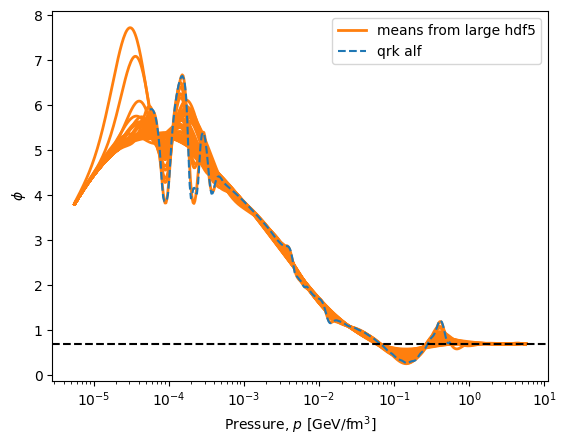

In [16]:
fig, ax = plt.subplots()
ax.set_xscale('log')

for key in gp_mean_dict['qrk'].keys():
    
    log_pressure, phi = gp_mean_dict['qrk'][key]

    if key == '0':
        label = 'means from large hdf5'
    else:
        label = None
    ax.plot(to_GeV_per_cubic_femtometre(np.exp(log_pressure)), phi, c='C1', lw=2, label=label)


file_path = f'../make-agnostic-processes/qrkagn/alf/gpr_gpr_quark-alf.hdf5'

with h5py.File(file_path, 'r') as f:
    cov = np.array(f['0']['cov'])
    mean = np.array(f['0']['mean'])

log_pressure = np.array([entry[0] for entry in mean])
phi = np.array([entry[1] for entry in mean])

ax.plot(to_GeV_per_cubic_femtometre(np.exp(log_pressure)), phi, c='C0', linestyle='--', zorder=3, label='qrk alf')

ax.axhline(np.log(2), c='k', ls='--', zorder=10)

ax.legend()

ax.set_xlabel(r'Pressure, $p$ [GeV/fm$^3$]')
_ = ax.set_ylabel(r'$\phi$')

Inspect GP means from a particular set

In [2]:
set = 10
gp_mean_dict = {}

for variety in ['qrk']:

    hdf5_path = f'../data/eos-draws-modified/{set:02}/{variety}agn/gpr_gpr_{variety}agn.hdf5'

    gp_mean_dict[variety] = {}

    with h5py.File(hdf5_path, 'r') as f:
        for key in f.keys():

            cov = np.array(f[key]['cov'])
            mean = np.array(f[key]['mean'])

            log_pressure = np.array([entry[0] for entry in mean])
            phi = np.array([entry[1] for entry in mean])

            gp_mean_dict[variety][key] = (log_pressure, phi)

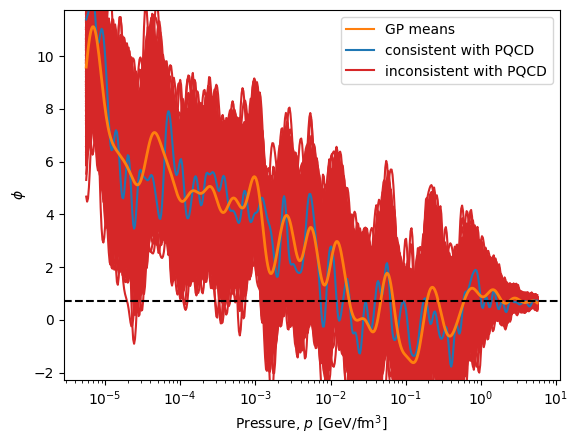

In [3]:
fig, ax = plt.subplots()
ax.set_xscale('log')

for variety in ['qrk']:
    for key in gp_mean_dict[variety].keys():
        log_pressure, phi = gp_mean_dict[variety][key]
        ax.plot(to_GeV_per_cubic_femtometre(np.exp(log_pressure)), phi, c='C1', zorder=2, alpha=1, lw=2)

xlim = ax.get_xlim()
ylim = ax.get_ylim()

N_samp = 1000

pqcd_region_dict = pqcd.get_pqcd_region()

for variety in ['qrk']:
    for n in range(N_samp):

        # if n != 3:
        #     continue

        eos = pd.read_csv(f'../data/eos-draws-modified/{set:02}/{variety}agn/DRAWmod1000-{int(n/1000):06}/eos-draw-{n:06}.csv')
        
        if pqcd.consistent_with_pqcd(eos, pqcd_region_dict):
            c='C0'
            alpha=1
            zorder=1
        
        else:
            c='C3'
            alpha=1
            zorder=0.5

        gp = pd.read_csv(f'../data/eos-draws-modified/{set:02}/{variety}agn/DRAWmod1000-{int(n/1000):06}/draw-gpr_{variety}agn-{n:06}.csv', comment='#')

        ax.plot(
            to_GeV_per_cubic_femtometre(np.exp(gp['log(pressurec2)'])),
            gp['phi'],
            color=c,
            alpha=alpha,
            zorder=zorder
        )

ax.set_xlim(xlim)
ax.set_ylim(ylim)

labels = ['GP means', 'consistent with PQCD', 'inconsistent with PQCD']
handles = [
    plt.Line2D([0], [0], color='C1'), 
    plt.Line2D([0], [0], color='C0'), 
    plt.Line2D([0], [0], color='C3')
    ]

ax.legend(handles, labels, loc='upper right')

ax.axhline(np.log(2), c='k', ls='--', zorder=10)

ax.set_xlabel(r'Pressure, $p$ [GeV/fm$^3$]')
_ = ax.set_ylabel(r'$\phi$')

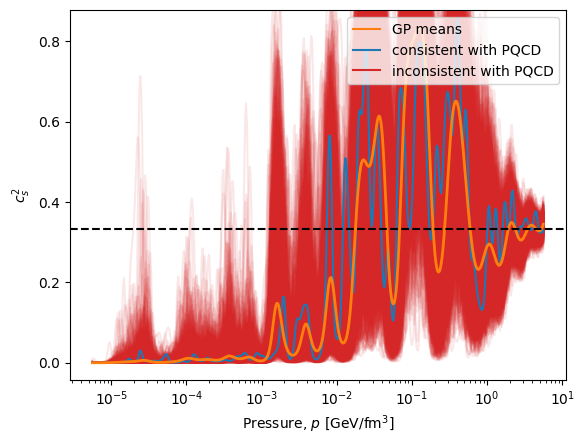

In [4]:
fig, ax = plt.subplots()
ax.set_xscale('log')

for variety in ['qrk']:
    for key in gp_mean_dict[variety].keys():
        log_pressure, phi = gp_mean_dict[variety][key]
        speed_of_sound_squared = 1/(1 + np.exp(phi))
        ax.plot(to_GeV_per_cubic_femtometre(np.exp(log_pressure)), speed_of_sound_squared, c='C1', zorder=2, alpha=1, lw=2)

xlim = ax.get_xlim()
ylim = ax.get_ylim()

N_samp = 1000

pqcd_region_dict = pqcd.get_pqcd_region()

for variety in ['qrk']:
    for n in range(N_samp):

        # if n != 3:
        #     continue

        eos = pd.read_csv(f'../data/eos-draws-modified/{set:02}/{variety}agn/DRAWmod1000-{int(n/1000):06}/eos-draw-{n:06}.csv')
        
        if pqcd.consistent_with_pqcd(eos, pqcd_region_dict):
            c='C0'
            alpha=1
            zorder=1
        
        else:
            c='C3'
            alpha=0.1
            zorder=0.5

        gp = pd.read_csv(f'../data/eos-draws-modified/{set:02}/{variety}agn/DRAWmod1000-{int(n/1000):06}/draw-gpr_{variety}agn-{n:06}.csv', comment='#')

        ax.plot(
            to_GeV_per_cubic_femtometre(np.exp(gp['log(pressurec2)'])),
            1/(1+np.exp(gp['phi'])),
            color=c,
            alpha=alpha,
            zorder=zorder
        )

ax.set_xlim(xlim)
ax.set_ylim(ylim)

labels = ['GP means', 'consistent with PQCD', 'inconsistent with PQCD']
handles = [
    plt.Line2D([0], [0], color='C1'), 
    plt.Line2D([0], [0], color='C0'), 
    plt.Line2D([0], [0], color='C3')
    ]

ax.legend(handles, labels, loc='upper right')

ax.axhline(1/3, c='k', ls='--', zorder=10)

ax.set_xlabel(r'Pressure, $p$ [GeV/fm$^3$]')
_ = ax.set_ylabel(r'$c_s^2$')

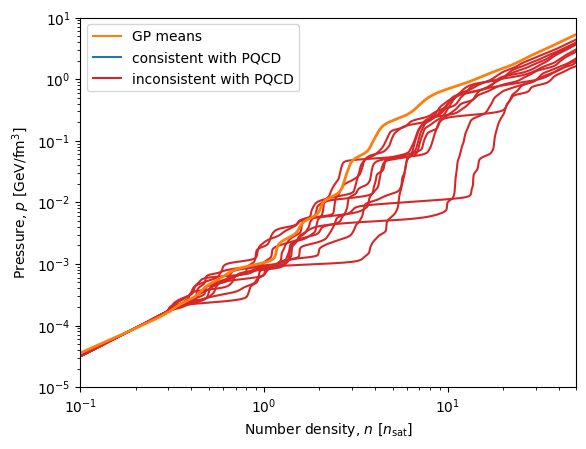

In [6]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')

for variety in ['qrk']:
    for key in gp_mean_dict[variety].keys():
        
        log_pressure, phi = gp_mean_dict[variety][key]

        eos, cols = integrate_phi(
            np.exp(log_pressure),
            phi,
            reference_pressurec2=3e11,
            sigma_logpressurec2=0,
            stitch_below_reference_pressure=True,
            include_baryon_density=True,
            include_cs2c2=True,
            include_baryon_chemical_potential=False,
            verbose=False
        )

        pressure_mean = to_GeV_per_cubic_femtometre(eos[:, cols.index('pressurec2')])
        energy_density_mean = to_GeV_per_cubic_femtometre(eos[:, cols.index('energy_densityc2')])
        number_density_mean = to_nucleons_per_cubic_femtometre(eos[:, cols.index('baryon_density')])

        ax.plot(number_density_mean/nsat, pressure_mean, c='C1', zorder=2, alpha=1, lw=2)

xlim = ax.get_xlim()
ylim = ax.get_ylim()

N_samp = 10

pqcd_region_dict = pqcd.get_pqcd_region()

for variety in ['qrk']:
    for n in range(N_samp):

        # if n != 3:
        #     continue

        eos = pd.read_csv(f'../data/eos-draws-modified/{set:02}/{variety}agn/DRAWmod1000-{int(n/1000):06}/eos-draw-{n:06}.csv')
        
        if pqcd.consistent_with_pqcd(eos, pqcd_region_dict):
            c='C0'
            alpha=1
            zorder=1
        
        else:
            c='C3'
            alpha=1
            zorder=0.5

        ax.plot(
            to_nucleons_per_cubic_femtometre(eos.baryon_density)/nsat,
            to_GeV_per_cubic_femtometre(eos.pressurec2),
            color=c,
            alpha=alpha,
            zorder=zorder
        )

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlim(0.1,50)
ax.set_ylim(1e-5,10)

labels = ['GP means', 'consistent with PQCD', 'inconsistent with PQCD']
handles = [
    plt.Line2D([0], [0], color='C1'), 
    plt.Line2D([0], [0], color='C0'), 
    plt.Line2D([0], [0], color='C3')
    ]

ax.legend(handles, labels, loc='upper left')

ax.set_xlabel(r'Number density, $n$ [$n_{\rm sat}$]')
_ = ax.set_ylabel(r'Pressure, $p$ [GeV/fm$^3$]')

-0.17448051674185883
-0.17448051674185883
-0.17448051674185883
-0.17448051674185883
-0.17448051674185883
-0.17448051674185883
-0.17448051674185883
-0.17448051674185883
-0.17448051674185883
-0.17448051674185883
-0.17448051674185883
-0.17448051674185883
-0.17448051674185883
-0.17448051674185883
-0.17448051674185883
-0.17448051674185883
-0.17448051674185883
-0.17448051674185883
-0.17448051674185883
-0.17448051674185883
-0.17448051674185883
-0.17448051674185883
-0.17448051674185883
-0.17448051674185883
-0.17448051674185883
-0.17448051674185883
-0.17448051674185883
-0.17448051674185883
-0.17448051674185883
-0.17448051674185883
-0.17448051674185883
-0.17448051674185883
-0.17448051674185883
-0.17448051674185883
-0.17448051674185883
-0.17448051674185883
-0.17448051674185883
-0.17448051674185883
-0.17448051674185883
-0.17448051674185883
-0.17448051674185883
-0.17448051674185883
-0.17448051674185883
-0.17448051674185883
-0.17448051674185883
-0.17448051674185883
-0.17448051674185883
-0.1744805167

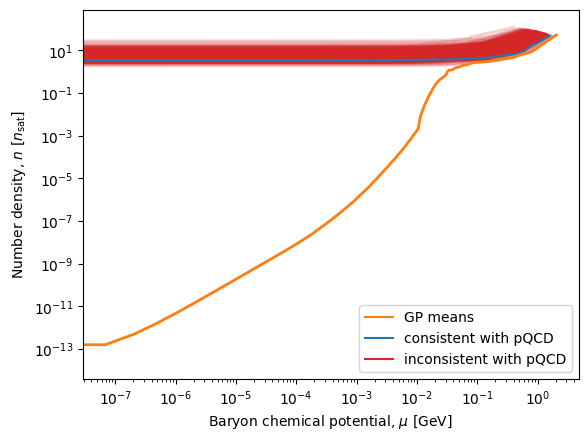

In [42]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')

for variety in ['qrk']:
    for key in gp_mean_dict[variety].keys():
        
        log_pressure, phi = gp_mean_dict[variety][key]

        eos, cols = integrate_phi(
            np.exp(log_pressure),
            phi,
            reference_pressurec2=3e11,
            sigma_logpressurec2=0,
            stitch_below_reference_pressure=True,
            include_baryon_density=True,
            include_cs2c2=True,
            include_baryon_chemical_potential=False,
            verbose=False
        )

        pressure_mean = to_GeV_per_cubic_femtometre(eos[:, cols.index('pressurec2')])
        energy_density_mean = to_GeV_per_cubic_femtometre(eos[:, cols.index('energy_densityc2')])
        number_density_mean = to_nucleons_per_cubic_femtometre(eos[:, cols.index('baryon_density')])

        chemical_potential_mean = (energy_density_mean+pressure_mean)/number_density_mean

        ax.plot((chemical_potential_mean/chemical_potential_mean[0])-1, number_density_mean/nsat, c='C1', zorder=2, alpha=1, lw=2)

xlim = ax.get_xlim()
ylim = ax.get_ylim()

N_samp = 1000

pqcd_region_dict = pqcd.get_pqcd_region()

for variety in ['qrk']:
    for n in range(N_samp):

        # if n != 3:
        #     continue

        eos = pd.read_csv(f'../data/eos-draws-modified/{set:02}/{variety}agn/DRAWmod1000-{int(n/1000):06}/eos-draw-{n:06}.csv')

        pressure = to_GeV_per_cubic_femtometre(eos.pressurec2.values)[0:]
        energy_density = to_GeV_per_cubic_femtometre(eos.energy_densityc2.values)[0:]
        number_density = to_GeV_per_cubic_femtometre(eos.baryon_density.values)[0:]

        chemical_potential = (energy_density+pressure)/number_density

        print(chemical_potential.min()-chemical_potential[0])
        
        if pqcd.consistent_with_pqcd(eos, pqcd_region_dict):
            c='C0'
            alpha=1
            zorder=1
        
        else:
            c='C3'
            alpha=0.1
            zorder=0.5

        ax.plot(
            (chemical_potential/chemical_potential[0])-1,
            number_density/nsat,
            color=c,
            alpha=alpha,
            zorder=zorder
        )

# ax.set_xlim(xlim)
# ax.set_ylim(ylim)

# ax.set_xlim(1e-4,10)
# ax.set_ylim(0.1, 50)

labels = ['GP means', 'consistent with pQCD', 'inconsistent with pQCD']
handles = [
    plt.Line2D([0], [0], color='C1'), 
    plt.Line2D([0], [0], color='C0'), 
    plt.Line2D([0], [0], color='C3')
    ]

ax.legend(handles, labels, loc='lower right')

ax.set_xlabel(r'Baryon chemical potential, $\mu$ [GeV]')
_ = ax.set_ylabel(r'Number density, $n$ [$n_{\rm sat}$]')

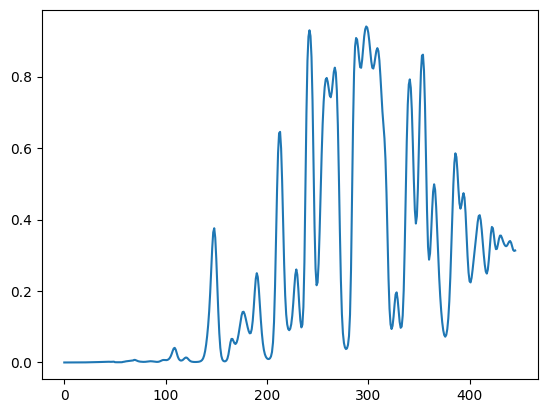

In [49]:
plt.plot(np.gradient(pressure, energy_density))

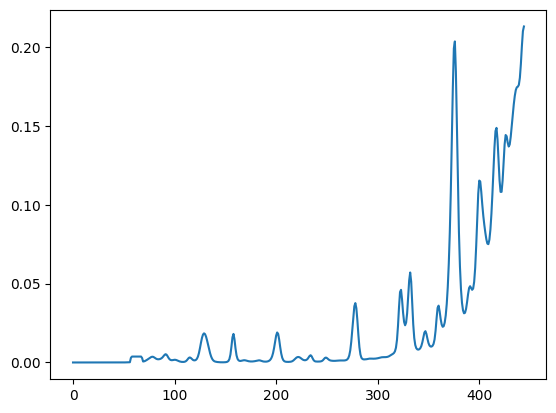

In [46]:
plt.plot(np.diff(number_density))

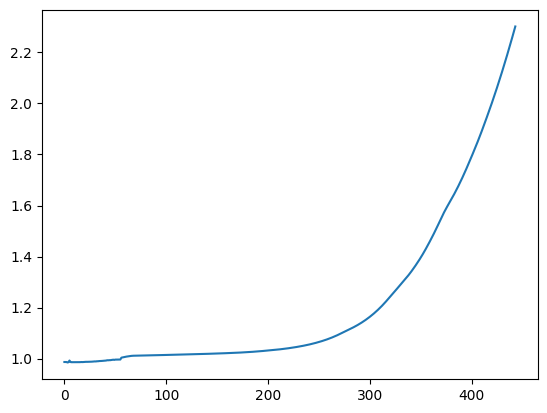

In [37]:
plt.plot(chemical_potential)

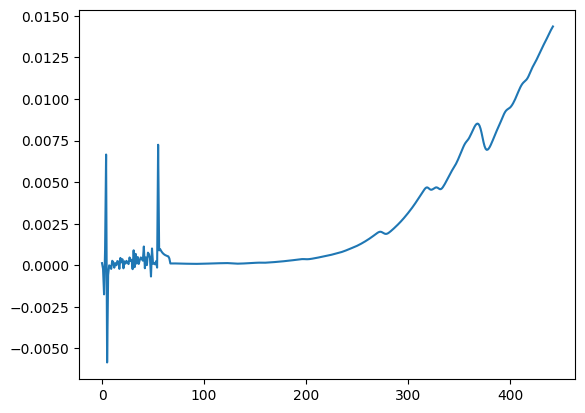

In [40]:
plt.plot(np.diff(chemical_potential))

In [15]:
from scipy.constants import m_u

In [23]:
to_GeV_per_cubic_femtometre(1000*m_u)/to_nucleons_per_cubic_femtometre(1)

1.5467823473711692e-24

In [8]:
chemical_potential_mean[0]

0.9314941024171477

In [9]:
chemical_potential[0]

1.080067518124324

Histogram the hyperparameters

In [20]:
hyperparam_names = ['poly_degree', 'sigma', 'length_scale', 'sigma_obs', 'model_multiplier']

consistent_hyperparams = {hp: [] for hp in hyperparam_names}
inconsistent_hyperparams = {hp: [] for hp in hyperparam_names}

s = 6
variety = 'had'
n = 0

with open(f'../data/eos-draws-modified/{set:02}/{variety}agn/DRAWmod1000-{int(n/1000):06}/draw-gpr_{variety}agn-{n:06}.csv', 'r') as f:
    for line in f.readlines():
        if line[0] == '#':
            hp_name = line.strip().split()[1].strip()
            hp_value = float(line.strip().split()[-1])
            print(hp_name)

poly_degree
sigma
length_scale
sigma_obs
model_multiplier


In [21]:
hyperparam_names = ['poly_degree', 'sigma', 'length_scale', 'sigma_obs', 'model_multiplier']

consistent_hyperparams = {hp: [] for hp in hyperparam_names}
inconsistent_hyperparams = {hp: [] for hp in hyperparam_names}

set = 6
N_samp = 2000
pqcd_region_dict = pqcd.get_pqcd_region()

for variety in ['had', 'hyp', 'qrk']:
    for n in range(N_samp):

        eos = pd.read_csv(f'../data/eos-draws-modified/{set:02}/{variety}agn/DRAWmod1000-{int(n/1000):06}/eos-draw-{n:06}.csv')
        
        if pqcd.consistent_with_pqcd(eos, pqcd_region_dict):
            consistent = True

        else:
            consistent = False

        with open(f'../data/eos-draws-modified/{set:02}/{variety}agn/DRAWmod1000-{int(n/1000):06}/draw-gpr_{variety}agn-{n:06}.csv', 'r') as f:
            for line in f.readlines():
                if line[0] == '#':
                    hp_name = line.strip().split()[1].strip()
                    hp_value = float(line.strip().split()[-1])

                    if consistent:
                        consistent_hyperparams[hp_name].append(hp_value)

                    else:
                        inconsistent_hyperparams[hp_name].append(hp_value)

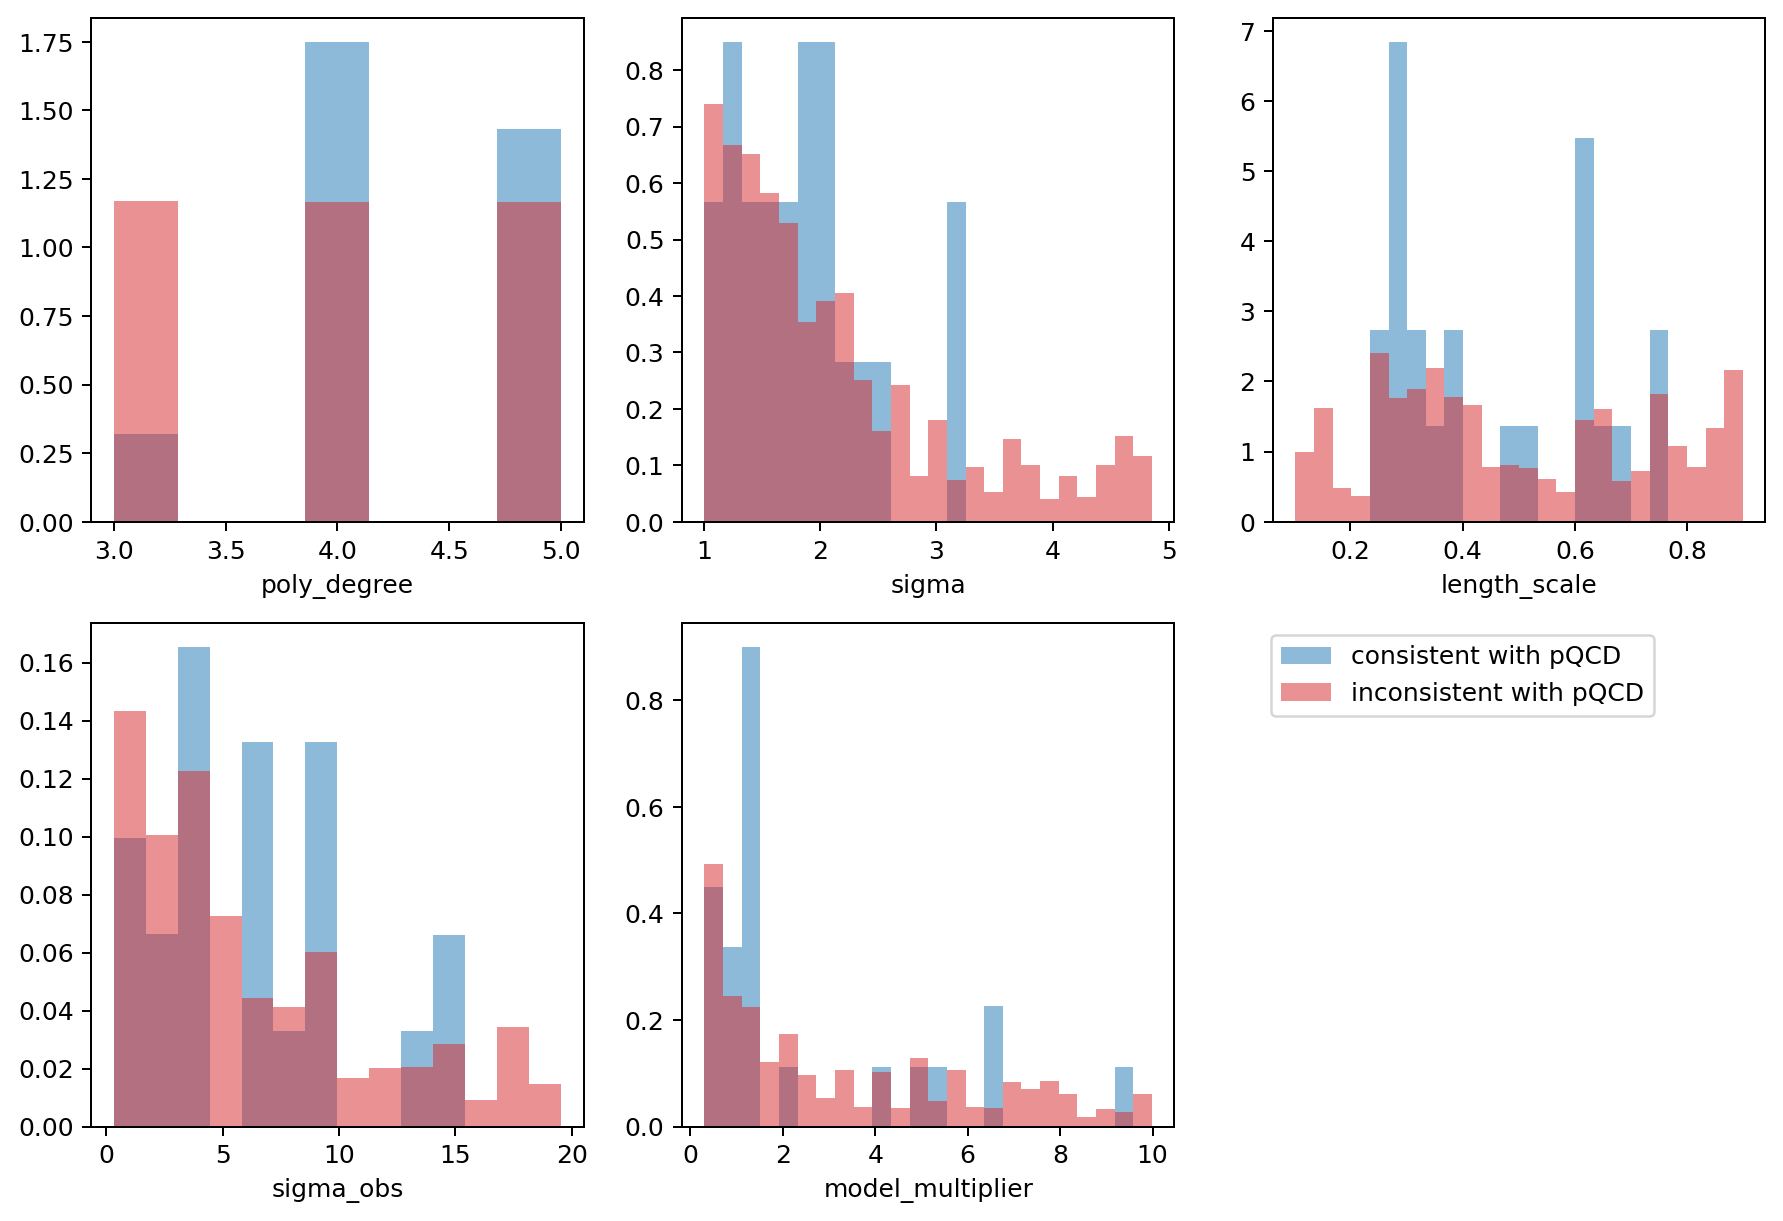

In [22]:
bin_counts = [8, 25, 25, 15, 25]
bin_dict = {}

for hp in hyperparam_names:
    min_val = min(min(consistent_hyperparams[hp]), min(inconsistent_hyperparams[hp]))
    max_val = max(max(consistent_hyperparams[hp]), max(inconsistent_hyperparams[hp]))
    bin_dict[hp] = np.linspace(min_val, max_val, bin_counts[hyperparam_names.index(hp)])

fig, axs = plt.subplots(2, 3, figsize=(12, 8), dpi=180)
axs[1, 2].axis('off')

for i, hp in enumerate(hyperparam_names):
    
        ax = axs.flatten()[i]
    
        ax.hist(consistent_hyperparams[hp], bins=bin_dict[hp], color='C0', alpha=0.5, label='consistent with pQCD', density=True)
        ax.hist(inconsistent_hyperparams[hp], bins=bin_dict[hp], color='C3', alpha=0.5, label='inconsistent with pQCD', density=True)
    
        ax.set_xlabel(hp)

_ = axs[1, 1].legend(loc='upper right', bbox_to_anchor=(2, 1))

In [23]:
consistent_hyperparams_array = np.array([consistent_hyperparams[hp] for hp in hyperparam_names]).T
inconsistent_hyperparams_array = np.array([inconsistent_hyperparams[hp] for hp in hyperparam_names]).T

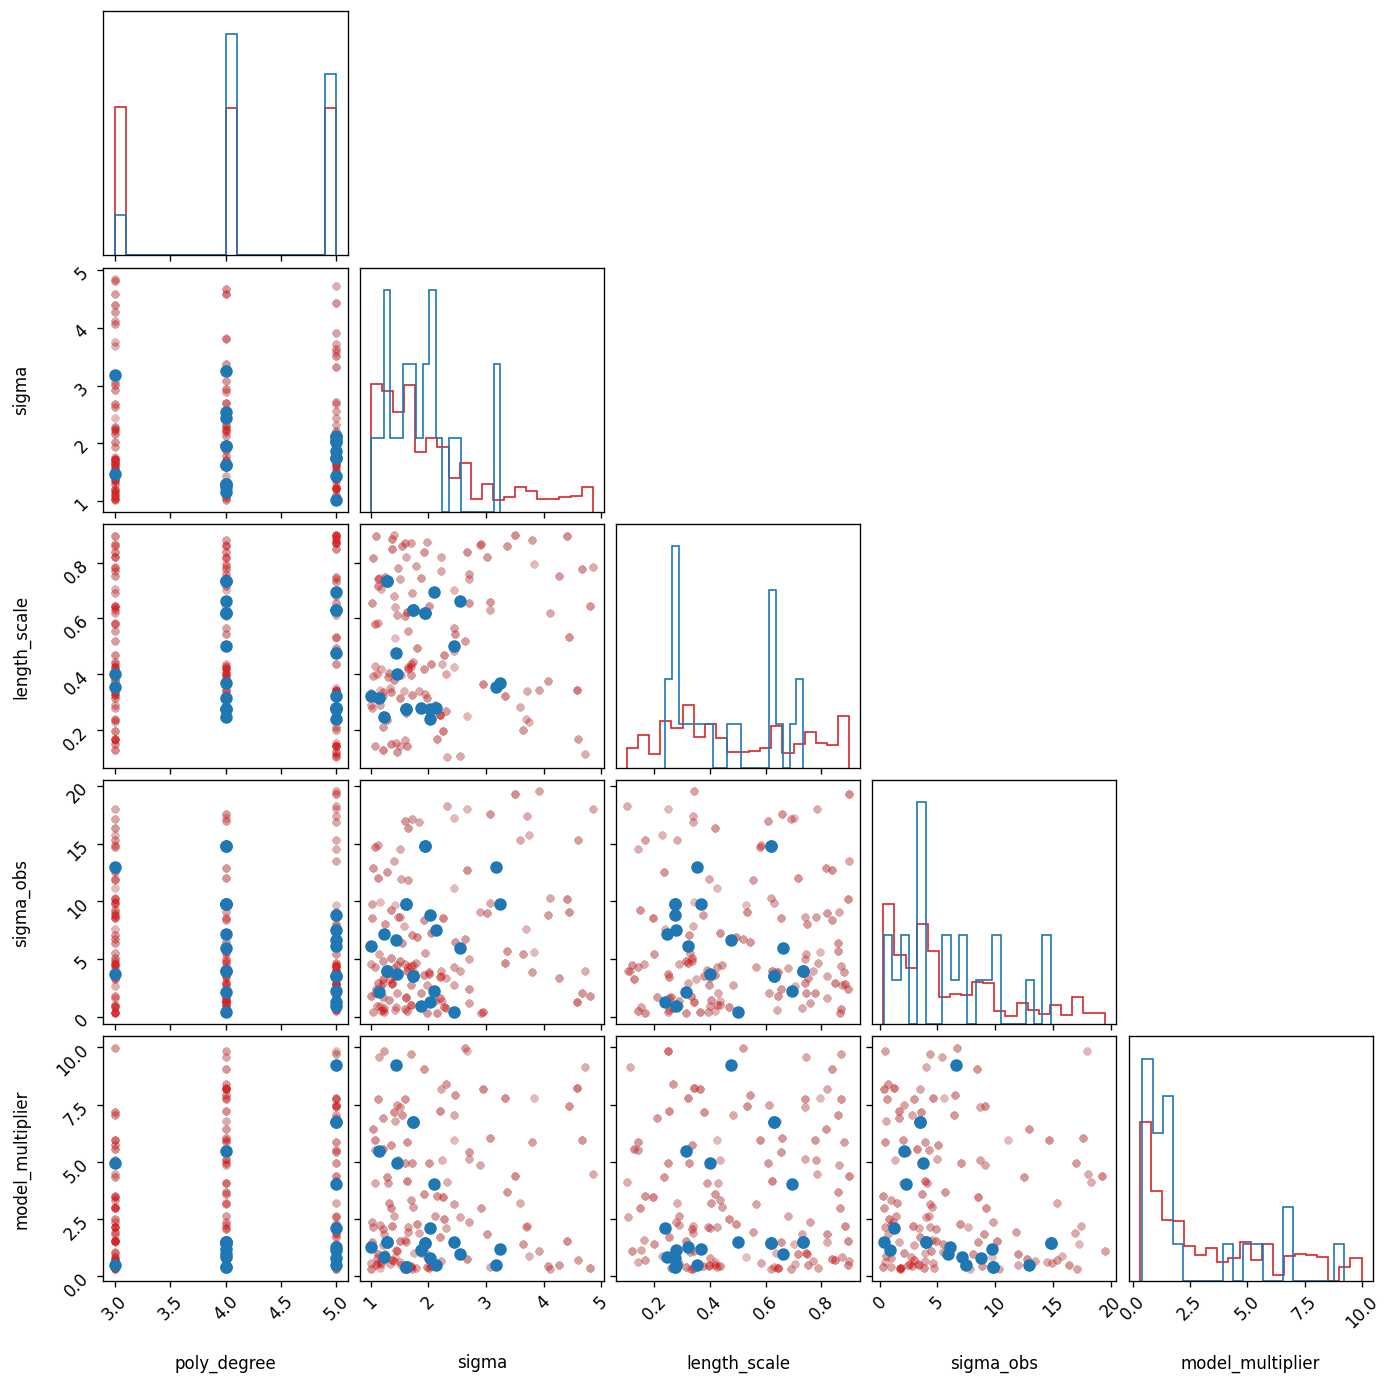

In [24]:
fig, ax = plt.subplots(5, 5, figsize=(12, 12), dpi=120)

_ = corner.corner(
    inconsistent_hyperparams_array, 
    labels=hyperparam_names, 
    fig=fig, 
    color='C3', 
    plot_contours=False,
    plot_density=False,
    hist_kwargs={'density': True},
    data_kwargs={'ms': 5, 'markeredgewidth': 0, 'alpha': 0.01}
    )

_ = corner.corner(
    consistent_hyperparams_array, 
    labels=hyperparam_names, 
    fig=fig, 
    color='C0', 
    plot_contours=False,
    plot_density=False,
    hist_kwargs={'density': True},
    data_kwargs={'ms': 7.5, 'markeredgewidth': 0, 'alpha': 1}
    )